In [1]:
import pylab as plb
import scipy as sy
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import math

In [2]:
### Overview
# Four regimes exist as a combination of a hydrological cycle and exogenous source:
# IDN + Met
# IDN + IDP
# COL + Met
# COL + IDP
# The terms are abbreviated as follows: 
# IDN (Intermediate drying), COL (continuous wet), these have different mean annual precipitation and seasonal amplitudes
# Met (meteorite source), IDP (Interplanetary Dust Particle source), these have different survival fractions

### Variable Declarations
w_i = 60.7e-9         # Mass fraction of organics in incoming interplanetary dust (IPD)
m_dot_I = 6e8         # IPD mass flux to Earth [kg/yr]
f_s = 0.32            # Survival fraction of organics during atmospheric entry
r = 40.               # Characteristic pond catchment radius [m]
rho = 2185.           # Density of rocky ejecta [kg/m^3]
r_p = 1.              # Pond radius [m]
A_p = math.pi*r_p**2  # Pond surface area [m^2]
r_g = 500.            # Gravitational settling length scale [m]

# Ponds evaporate at different rates when the water level is at a different depth
tau_d_1cm = 4.9e-3    # Drying timescale for a 1 cm water layer [yr]
tau_d_5cm = 0.12      # Drying timescale for a 5 cm layer [yr]
tau_d_10cm = 0.48     # Drying timescale for a 10 cm layer [yr]

R_plus = 6371000
gamma = 31557600      # Seconds per year
rho_w = 1000.         # Water density [kg/m^3]

# Temperature of experiments (conversion from C to K)
# T_50 = (273.15+50)
# T_65 = (273.15+65)
# T_80 = (273.15+80)

molecules = {
    "Adenine": {"mu": 0.13513, "rho": 1470, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Guanine": {"mu": 0.15113, "rho": 2200, "Ea": 6330, "B": 9.40}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Uracil": {"mu": 0.1120868, "rho": 1320, "Ea": 7649, "B": 11.76}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Cytosine": {"mu": 0.1111, "rho": 1550, "Ea": 5620, "B": 8.69}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Thymine": {"mu": 0.1261133, "rho": 1230, "Ea": 7709, "B": 11.24}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "2-Amino-oxazole": {"mu": 0.084077, "rho": 1200, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Ribose": {"mu": 0.15013, "rho": 800, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Formaldehyde": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Xanthine": {"mu": 0.15211, "rho": 1600, "Ea": 6230, "B": 9.42}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Hypoxanthine": {"mu": 0.1361115, "rho": 2000, "Ea": 5270, "B": 7.95}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "HCN": {"mu": 0.0270253, "rho": 687, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "H2CO": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": 6.01494508e-12, "ox": 1.15285175e-09}}
    "Urea": {"mu": 0.06006 , "rho": 1335, "Ea" : 9640, "B": 12.1}
}

### Hydrolysis rate constants
# Arrhenius rate constants for hydrolysis different molecules at T= 50, 65, 85 C
# k_i_50 = 10**(-5902/T_50 + 8.15)   # all species at T = 50
# k_A_65 = 10**(-5902/T_65 + 8.15)   # adenine
# k_i_80 = 10**(-5902/T_80 + 8.15)   # all species at T = 85


### Precipitation Models
# IDN is for intermediate drying: six months wet, six months dry
# COL is for continuous wet, minor fluctuations
tau_s = 1.0         # Seasonal period [yr]
P_CAM = 3.5         # Precipitation rate [m/yr] for model
P_IDN = 4.5         
P_COL = 6.
delta_CAM = 0.5     # Seasonal amplitude of precipitation - how much rainfall varies/oscillates seasonally
delta_IDN = 0.2
delta_COL = 0.5
sp_CAM = 0.3        # Seasonal phase shift - align sinusoidal cycle to calendar year
sp_IDN = 0.85
sp_COL = 0.3

min_water = 0.001     # Minimum pond water depth [m] i.e. 1 mm 
S = 0.95              # Seepage rate 0.36525 (fraction water lost per year)
Phi = 1e-4            # Photonic attenuation factor
F = 0.4               # W/m^2
lambda_uv = 225e-9    # UV wavelength [m]
h = 6.626e-34         # Planck’s constant [J·s]
c = 2.9979e8          # Speed of light [m/s]

### Molecular properties and conversion factors
# mu = .13513           # Molar mass [kg/mol]
# mu_HCN = 0.0270253
# mu_Adenine = 0.13513
# mu_formaldehyde = 0.030031

N_A = 6.022e23         # Avogadro's number
# rho_i = molecules['Adenine']['rho']
# d = 2*(3*mu/(4*math.pi*N_A*rho_i))**(1./3) # Molecular diameter used to compare mass layer to pond surface area A_p
# rho_F = 815
# d_F = 2*(3*mu_formaldehyde/(4*math.pi*N_A*rho_F))**(1./3)


#Fraction of surviving organics during entry
f_s_IDP = 0.06
f_s_Met = 0.32

#Organic Haze Values
#Trainer et al. (2006) 1e13 to 3e15 g/yr
#m_dot_haze_5 = 522.e-6/(6/365.25)  # 522 mg / 6 days to kg/yr our experiments
#m_dot_haze_05 = 72.e-6/(6/365.25)
#m_dot_haze_5_min = 1.e11*7.
m_dot_haze_05_min = 4.9e11
#m_dot_haze_5_max = 1.e11*7.
m_dot_haze_05_max = 8.9e14

C_Adenine_5 = 2.1e-6 # 2.1ppm
C_Adenine_05_max = 6.3e-6
C_Adenine_05_min = 4.6e-6

#UV photodissociation rate (kg/yr/m^2)
# M_uv_dot_A = ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A))
# M_uv_dot_H = ((Phi*F*lambda_uv*gamma*mu_HCN)/(h*c*N_A))
# M_uv_dot_F = ((Phi*F*lambda_uv*gamma*mu_formaldehyde)/(h*c*N_A))

#Experimental yields
Adenine_lower = 0.005
Adenine_upper = 0.18

Formaldehyde = 0.036

# Mass influx from rain-out, data gathered from ChemKM non-equilibrium atmospheric models
HCN_mass_influx_ox = 3.42599458e-12
HCN_mass_influx_red = 1.25776186e-07
H2CN_mass_influx_red = 6.01494508e-12
H2CN_mass_influx_ox = 1.15285175e-09 #4.11794768e-09

m_dot_HCN_ox = HCN_mass_influx_ox*4*math.pi*R_plus**2
m_dot_HCN_red = HCN_mass_influx_red*4*math.pi*R_plus**2
m_dot_H2CO_red = H2CN_mass_influx_red*4*math.pi*R_plus**2


#Plot A
m_dot_Adenine_red = m_dot_HCN_red*molecules['Adenine']['mu']/molecules['HCN']['mu']
m_dot_Adenine_ox = m_dot_HCN_ox*molecules['Adenine']['mu']/molecules['HCN']['mu']

# rho_HCN = 687
# d_HCN = 2*(3*molecules['HCN']['mu']/(4*math.pi*N_A*molecules['HCN']['rho']))**(1./3)


# E_50 = (S-0.12 + 0.06*50)
E_65 = (S-0.12 + 0.06*65)
# E_80 = (S-0.12 + 0.06*80)

### Initial conditions and time grid
tmax = 8 # years
level = 16
nt = (2**level) + 1 # Choosing nt to have twice as many grid points as nx
# Array for plotting
t = np.linspace(0,tmax,nt)
# Calculate delta_t - time step
delta_t = t[2] - t[1]


#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S

m_i0 = (4./3)*w_i*f_s*r**3*rho*A_p/r_g**2
    
L_IDN_65_IDP = np.zeros(shape=(nt))
L_IDN_65_Met = np.zeros(shape=(nt))
L_COL_65_Met = np.zeros(shape=(nt))
L_COL_65_IDP = np.zeros(shape=(nt))

m_IDN_65_IDP = np.zeros(shape=(nt))
m_IDN_65_Met = np.zeros(shape=(nt))
m_COL_65_Met = np.zeros(shape=(nt))
m_COL_65_IDP = np.zeros(shape=(nt))

m_IDN_65_IDP_A = np.zeros(shape=(nt))
m_IDN_65_Met_A = np.zeros(shape=(nt))
m_COL_65_Met_A = np.zeros(shape=(nt))
m_COL_65_IDP_A = np.zeros(shape=(nt))

C_IDN_65_IDP = np.zeros(shape=(nt))
C_IDN_65_Met = np.zeros(shape=(nt))
C_COL_65_Met = np.zeros(shape=(nt))
C_COL_65_IDP = np.zeros(shape=(nt))

#HCN initialize
m_IDN_65_HCN_ox = np.zeros(shape=(nt))
C_IDN_65_HCN_ox = np.zeros(shape=(nt))
m_COL_65_HCN_ox = np.zeros(shape=(nt))
C_COL_65_HCN_ox = np.zeros(shape=(nt))
m_IDN_65_HCN_red = np.zeros(shape=(nt))
C_IDN_65_HCN_red = np.zeros(shape=(nt))
m_COL_65_HCN_red = np.zeros(shape=(nt))
C_COL_65_HCN_red = np.zeros(shape=(nt))

#Biomolecule initialize
m_IDN_65_Adenine_red = np.zeros(shape=(nt))
C_IDN_65_Adenine_red = np.zeros(shape=(nt))
m_COL_65_Adenine_red = np.zeros(shape=(nt))
C_COL_65_Adenine_red = np.zeros(shape=(nt))

m_IDN_65_Adenine_ox = np.zeros(shape=(nt))
C_IDN_65_Adenine_ox = np.zeros(shape=(nt))
m_IDN_65_Formaldehyde_red = np.zeros(shape=(nt))
C_IDN_65_Formaldehyde_red = np.zeros(shape=(nt))

m_IDN_65_H2CO_red = np.zeros(shape=(nt))
C_IDN_65_H2CO_red = np.zeros(shape=(nt))


#Initialize for Hazes
m_IDN_65_Adenine_haze5 = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze5 = np.zeros(shape=(nt))

m_IDN_65_Adenine_haze05_min = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze05_min = np.zeros(shape=(nt))
m_IDN_65_Adenine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze05_max = np.zeros(shape=(nt))

# Array for plotting
t = np.linspace(0,tmax,nt)

# Calculate delta_t
# delta_t = t[2] - t[1]

#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S

#Initial conditions

#Water levels
L_IDN_65_IDP[0] = r_p - min_water
L_IDN_65_Met[0] = r_p - min_water
L_COL_65_Met[0] = r_p - min_water
L_COL_65_IDP[0] = r_p - min_water

#Water mass
m_IDN_65_IDP[0] = math.pi*rho_w*r_p**2*(r_p-L_IDN_65_Met[0])
m_IDN_65_Met[0] = math.pi*rho_w*r_p**2*(r_p-L_IDN_65_Met[0])
m_COL_65_Met[0] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_Met[0])
m_COL_65_IDP[0] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_Met[0])

#Biomolecule masses and concentrations
m_IDN_65_IDP_A[0] = 0
m_IDN_65_Met_A[0] = 0
m_COL_65_Met_A[0] = 0
m_COL_65_IDP_A[0] = 0

C_IDN_65_IDP[0] = 0
C_IDN_65_Met[0] = 0
C_COL_65_Met[0] = 0
C_COL_65_IDP[0] = 0

m_IDN_65_HCN_ox[0] = 0
C_IDN_65_HCN_ox[0] = 0
m_COL_65_HCN_ox[0] = 0
C_COL_65_HCN_ox[0] = 0
m_IDN_65_HCN_red[0] = 0
C_IDN_65_HCN_red[0] = 0
m_COL_65_HCN_red[0] = 0
C_COL_65_HCN_red[0] = 0

m_IDN_65_Adenine_red[0] = 0
C_IDN_65_Adenine_red[0] = 0
m_COL_65_Adenine_red[0] = 0
C_COL_65_Adenine_red[0] = 0

m_IDN_65_Adenine_ox[0] = 0
C_IDN_65_Adenine_ox[0] = 0
m_IDN_65_Formaldehyde_red[0] = 0
C_IDN_65_Formaldehyde_red[0] = 0

m_IDN_65_H2CO_red[0] = 0
C_IDN_65_H2CO_red[0] = 0

m_IDN_65_Adenine_haze5[0] = 0
C_IDN_65_Adenine_haze5[0] = 0
m_IDN_65_Adenine_haze05_min[0] = 0
C_IDN_65_Adenine_haze05_min[0] = 0
m_IDN_65_Adenine_haze05_max[0] = 0
C_IDN_65_Adenine_haze05_max[0] = 0

pause_IDN_65_Met = 0
pause_COL_65_Met = 0

m_i0 = (4./3)*w_i*f_s_Met*r**3*rho*A_p/r_g**2

In [3]:
# def M_uv_dot(mm):
#     mu = molecules[mm]["mu"]
#     return ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A))

# def diameter(mm):
#     mu = molecules[mm]["mu"]
#     rho = molecules[mm]["rho"]
#     return 2*(3*mu/(4*math.pi*N_A*rho))**(1./3)

# def k_hydrolysis(mm):
#     Ea = molecules[mm]["Ea"]
#     B = molecules[mm]["B"]
#     T=273.15+65
#     return 10**(-Ea/T + B)

In [4]:
for mm in molecules:
    mu = molecules[mm]["mu"]
    rho = molecules[mm]["rho"]
    Ea = molecules[mm]["Ea"]
    B = molecules[mm]["B"]
    T=273.15+65
    
    # calculating additional parameters
    M_uv_dot = ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A))
    diameter = 2*(3*mu/(4*math.pi*N_A*rho))**(1./3)
    k_hydrolysis = 10**(-Ea/T + B)
    
    # updating dicitonary
    molecules[mm].update({'M_uv_dot' : M_uv_dot})
    molecules[mm].update({'d' : diameter})
    molecules[mm].update({'k_hydrolysis' : k_hydrolysis})

In [5]:
print(molecules)

{'Adenine': {'mu': 0.13513, 'rho': 1470, 'Ea': 5902, 'B': 8.15, 'M_uv_dot': 0.000320840310847656, 'd': 6.630786167871198e-10, 'k_hydrolysis': 4.968294194943793e-10}, 'Guanine': {'mu': 0.15113, 'rho': 2200, 'Ea': 6330, 'B': 9.4, 'M_uv_dot': 0.00035882924723160104, 'd': 6.017224419865574e-10, 'k_hydrolysis': 4.791779452831005e-10}, 'Uracil': {'mu': 0.1120868, 'rho': 1320, 'Ea': 7649, 'B': 11.76, 'M_uv_dot': 0.00026612864466749834, 'd': 6.457737517436547e-10, 'k_hydrolysis': 1.3799425572173103e-11}, 'Cytosine': {'mu': 0.1111, 'rho': 1550, 'Ea': 5620, 'B': 8.69, 'M_uv_dot': 0.00026378567701601855, 'd': 6.103060321008492e-10, 'k_hydrolysis': 1.1753216473852046e-08}, 'Thymine': {'mu': 0.1261133, 'rho': 1230, 'Ea': 7709, 'B': 11.24, 'M_uv_dot': 0.0002994318831793362, 'd': 6.87657422412171e-10, 'k_hydrolysis': 2.769650436812241e-12}, '2-Amino-oxazole': {'mu': 0.084077, 'rho': 1200, 'Ea': 5902, 'B': 8.15, 'M_uv_dot': 0.00019962473777205932, 'd': 6.056924996937126e-10, 'k_hydrolysis': 4.96829419

In [6]:
def update_molecule_mass(
    n, m_arr, dry, m_dot, M_uv_dot, rho, d, k_val=0, gamma=0,
    is_nucleotide=False, hydrolysis=True
):
    """
    Update molecule mass based on environmental state (dry/wet).
    """
    # mu = molecules[mm]["mu"]
    # rho = molecules[mm]["rho"]
    # k_val = k_hydrolysis(mm)
    # M_uv_dot = M_uv_dot(mm)
    # d = diameter(mm)
    
    A = m_arr[n] / (rho * d)
    add_flux = (delta_t * m_dot * A_p) / (4 * np.pi * R_plus**2)

    if dry:
        if A < A_p:
            loss_uv = delta_t * M_uv_dot * m_arr[n] / (rho * d)
        else:
            loss_uv = delta_t * M_uv_dot * A_p
        m_next = m_arr[n] + add_flux - loss_uv
    else:
        seepage_loss = delta_t * m_arr[n] * m_seepage_rate / m_IDN_65_IDP[n]
        hydrolysis_loss = delta_t * gamma * k_val * m_arr[n] if hydrolysis else 0
        m_next = m_arr[n] + add_flux - seepage_loss - hydrolysis_loss

    return max(m_next, 0)

# def update_molecule_mass(
#     n, m_arr, dry, m_dot, M_uv_dot, rho, d, k_val=0, gamma=0,
#     is_nucleotide=False, hydrolysis=True, water_mass=None, 
#     t=None, pause=0, tau_d=None, m_i0=None
# ):
#     A = m_arr[n] / (rho * d)
#     add_flux = 0

#     if dry:
#         if A < A_p:
#             loss_uv = delta_t * M_uv_dot * m_arr[n] / (rho * d)
#         else:
#             loss_uv = delta_t * M_uv_dot * A_p
#         m_next = m_arr[n] - loss_uv
#         pause += 1
#     else:
#         # Optional decay-based meteoritic flux
#         if m_i0 and t is not None and tau_d is not None:
#             eff_t = t[n - pause] if (n - pause >= 0) else 0
#             decay_input = delta_t * m_i0 * np.exp(-eff_t * (gamma * k_val + 1. / tau_d)) / tau_d
#         else:
#             decay_input = 0

#         seepage_loss = delta_t * m_arr[n] * m_seepage_rate / water_mass[n] if water_mass is not None else 0
#         hydrolysis_loss = delta_t * gamma * k_val * m_arr[n] if hydrolysis else 0

#         m_next = m_arr[n] + decay_input + add_flux - seepage_loss - hydrolysis_loss

#     return max(m_next, 0), pause

# update_pond_level(L_IDN_65_Met[n], E_65, P_IDN, delta_IDN, t[n], sp_IDN, tau_s, delta_t, r_p, min_water)
# update_pond_level(L_COL_65_Met[n], E_65, P_COL, delta_COL, t[n], sp_COL, tau_s, delta_t, r_p, min_water)
# def update_pond_level(L_prev, E, P, delta, t, sp, tau_s, delta_t, r_p, min_water):
def update_pond_level(L_prev, t, is_IDN):
    if is_IDN:
        L_new = L_prev + E_65 * delta_t - delta_t * P_IDN * (1 + delta_IDN * np.sin(2 * math.pi * (t - sp_IDN) / tau_s))
    else:
        L_new = L_prev + E_65 * delta_t - delta_t * P_COL * (1 + delta_COL * np.sin(2 * math.pi * (t - sp_COL) / tau_s))
    return min(max(L_new, 0), r_p - min_water)

# def update_adenine_mass(L, m_A_prev, m_water_prev, pause, t, n, A_p, m_i0, gamma, tau_d, delta_t, m_seepage_rate, is_IDN):
def update_adenine_mass(L, m_A_prev, m_water_prev, pause, is_IDN):
    mm = 'Adenine'
    
    rho_i = molecules[mm]['rho']
    d = molecules[mm]['d']
    M_uv_dot_A = molecules[mm]['M_uv_dot']
    k_A = molecules[mm]['k_hydrolysis']
    k_photo = 0.063 # hr-1
    k_photo_yr = k_photo * 365.25 * 24 # yr-1
    
    if L >= (r_p - min_water):  # Pond dry
        # UV-driven loss
        if m_A_prev / (rho_i * d) < A_p:
            m_A_new = m_A_prev - delta_t * M_uv_dot_A * m_A_prev / (rho_i * d)
        else:
            m_A_new = m_A_prev - delta_t * M_uv_dot_A * A_p
        pause += 1
    else:  # Pond wet
        decay_factor = np.exp(-t[n - pause] * (gamma * k_A + (1. / tau_d_1cm)))
        input_term = delta_t * m_i0 * decay_factor / tau_d_1cm
        hydrolysis_term = delta_t * gamma * k_A * m_A_prev
        seepage_term = delta_t * m_A_prev * m_seepage_rate / m_water_prev
        photolysis_term = delta_t * k_photo_yr * m_A_prev 
        
        m_A_new = m_A_prev + input_term - hydrolysis_term - seepage_term - photolysis_term
    return max(m_A_new, 0), pause

def update_water_mass(L):
    return math.pi * rho_w * r_p**2 * (r_p - L)

In [7]:
for n in range(nt - 1):
    # --- IDN Model ---
    L_IDN_65_Met[n+1] = update_pond_level(L_IDN_65_Met[n], t[n], is_IDN=True)
    m_IDN_65_Met_A[n+1], pause_IDN_65_Met = update_adenine_mass(
        L_IDN_65_Met[n+1], m_IDN_65_Met_A[n], m_IDN_65_Met[n], pause_IDN_65_Met,
        is_IDN=True
    )
    m_IDN_65_Met[n+1] = update_water_mass(L_IDN_65_Met[n+1])

    # --- COL Model ---
    L_COL_65_Met[n+1] = update_pond_level(L_COL_65_Met[n], t[n], is_IDN =False)
    
    m_COL_65_Met_A[n+1], pause_COL_65_Met = update_adenine_mass(
        L_COL_65_Met[n+1], m_COL_65_Met_A[n], m_COL_65_Met[n], pause_COL_65_Met,
        is_IDN=False
    )
    
    m_COL_65_Met[n+1] = update_water_mass(L_COL_65_Met[n+1])

In [8]:
for n in range(nt - 1):
    # Water level update
    seasonal_factor = 1 + delta_IDN * np.sin(2 * math.pi * (t[n] - sp_IDN) / tau_s)
    L_IDN_65_IDP[n+1] = L_IDN_65_IDP[n] + E_65 * delta_t - (delta_t * P_IDN) * seasonal_factor
    L_IDN_65_IDP[n+1] = max(L_IDN_65_IDP[n+1], 0)
    dry = L_IDN_65_IDP[n+1] >= (r_p - min_water)
    if dry:
        L_IDN_65_IDP[n+1] = r_p - min_water

    # Pond water mass
    m_IDN_65_IDP[n+1] = math.pi * rho_w * r_p**2 * (r_p - L_IDN_65_IDP[n+1])

    # Update all molecules systematically
    molecules_list = [
        # name, array, m_dot, M_uv_dot, rho, d, k, hydrolysis
        ('A', m_IDN_65_IDP_A, w_i*m_dot_I*f_s_IDP, molecules['Adenine']['M_uv_dot'], molecules['Adenine']['rho'], molecules['Adenine']['d'], molecules['Adenine']['k_hydrolysis'], True),
        ('HCN_ox', m_IDN_65_HCN_ox, m_dot_HCN_ox, molecules['HCN']['M_uv_dot'], molecules['HCN']['rho'], molecules['HCN']['d'], 0, False),
        ('H2CO_red', m_IDN_65_H2CO_red, m_dot_H2CO_red, molecules['H2CO']['M_uv_dot'], molecules['H2CO']['rho'], molecules['H2CO']['d'], 0, False),
        ('HCN_red', m_IDN_65_HCN_red, m_dot_HCN_red, molecules['HCN']['M_uv_dot'], molecules['HCN']['rho'], molecules['HCN']['d'], 0, False),
        ('Adenine_red', m_IDN_65_Adenine_red, m_dot_Adenine_red, molecules['Adenine']['M_uv_dot'], molecules['Adenine']['rho'], molecules['Adenine']['d'], molecules['Adenine']['k_hydrolysis'], True),
        ('Adenine_ox', m_IDN_65_Adenine_ox, m_dot_Adenine_ox, molecules['Adenine']['M_uv_dot'], molecules['Adenine']['rho'], molecules['Adenine']['d'], 0, False),
    ]

    for name, arr, m_dot, M_uv_dot, rho, d, k_val, do_hydrolysis in molecules_list:
        arr[n+1] = update_molecule_mass(n, arr, dry, m_dot, M_uv_dot, rho, d, k_val, gamma, hydrolysis=do_hydrolysis)
print(m_IDN_65_IDP_A)

[0.00000000e+00 1.64295643e-18 3.10630236e-18 ... 2.92429386e-16
 2.92945019e-16 2.93460936e-16]


In [9]:
#Wet models (Ponds don't dry completely) IDP and aqueous production
for n in range(nt - 1):
    # Water level
    seasonal_factor = 1 + delta_COL * np.sin(2 * math.pi * (t[n] - sp_COL) / tau_s)
    L_COL_65_IDP[n+1] = E_65 * delta_t + L_COL_65_IDP[n] - (delta_t * P_COL) * seasonal_factor
    L_COL_65_IDP[n+1] = max(L_COL_65_IDP[n+1], 0)
    
    dry = L_COL_65_IDP[n+1] >= (r_p - min_water)
    if dry:
        L_COL_65_IDP[n+1] = r_p - min_water

    # Pond water mass
    m_COL_65_IDP[n+1] = math.pi * rho_w * r_p**2 * (r_p - L_COL_65_IDP[n+1])

    # Molecules
    molecules_list2 = [
        # name, array, m_dot, M_uv_dot, rho, d, k, hydrolysis
        ('A', m_COL_65_IDP_A, w_i*m_dot_I*f_s_IDP, molecules['Adenine']['M_uv_dot'], molecules['Adenine']['rho'], molecules['Adenine']['d'], molecules['Adenine']['k_hydrolysis'], True),
        ('HCN_ox', m_COL_65_HCN_ox, m_dot_HCN_ox, molecules['HCN']['M_uv_dot'], molecules['HCN']['rho'], molecules['HCN']['d'], molecules['Adenine']['k_hydrolysis'], True),
        ('HCN_red', m_COL_65_HCN_red, m_dot_HCN_red, molecules['HCN']['M_uv_dot'], molecules['HCN']['rho'], molecules['HCN']['d'], molecules['Adenine']['k_hydrolysis'], True),
        ('Adenine_red', m_COL_65_Adenine_red, m_dot_Adenine_red, molecules['Adenine']['M_uv_dot'], molecules['Adenine']['rho'], molecules['Adenine']['d'], molecules['Adenine']['k_hydrolysis'], True),
    ]

    for name, arr, m_dot, M_uv_dot, rho, d, k_val, do_hydrolysis in molecules_list2:
        arr[n+1] = update_molecule_mass(n, arr, dry, m_dot, M_uv_dot, rho, d, k_val, gamma, hydrolysis=do_hydrolysis)


In [10]:
for n in range(nt - 1):
    concentration_defs = [
        # (concentration array, numerator, denominator)
        (C_IDN_65_HCN_ox,        m_IDN_65_HCN_ox,        m_IDN_65_IDP),
        (C_COL_65_HCN_ox,        m_COL_65_HCN_ox,        m_COL_65_IDP),
        (C_IDN_65_HCN_red,       m_IDN_65_HCN_red,       m_IDN_65_IDP),
        (C_COL_65_HCN_red,       m_COL_65_HCN_red,       m_COL_65_IDP),
        (C_IDN_65_IDP,           m_IDN_65_IDP_A,         m_IDN_65_IDP),
        (C_COL_65_IDP,           m_COL_65_IDP_A,         m_COL_65_IDP),
        (C_IDN_65_Met,           m_IDN_65_Met_A,         m_IDN_65_Met),
        (C_COL_65_Met,           m_COL_65_Met_A,         m_COL_65_Met),
        (C_IDN_65_Adenine_red,   m_IDN_65_Adenine_red,   m_IDN_65_IDP),
        (C_COL_65_Adenine_red,   m_COL_65_Adenine_red,   m_COL_65_IDP),
        (C_IDN_65_Adenine_ox,    m_IDN_65_Adenine_ox,    m_IDN_65_IDP),
        # (C_IDN_65_Guanine_red,   m_IDN_65_Guanine_red,   m_IDN_65_IDP),
        # (C_IDN_65_Uracil_red,    m_IDN_65_Uracil_red,    m_IDN_65_IDP),
        # (C_IDN_65_Cytosine_red,  m_IDN_65_Cytosine_red,  m_IDN_65_IDP),
        # (C_IDN_65_Thymine_red,   m_IDN_65_Thymine_red,   m_IDN_65_IDP),
        # (C_IDN_65_2amino_red,    m_IDN_65_2amino_red,    m_IDN_65_IDP),
        # (C_IDN_65_Ribose_red,    m_IDN_65_Ribose_red,    m_IDN_65_IDP),
        (C_IDN_65_Formaldehyde_red, m_IDN_65_Formaldehyde_red, m_IDN_65_IDP),
        (C_IDN_65_H2CO_red,      m_IDN_65_H2CO_red,      m_IDN_65_IDP),

        # Hazes
        # (C_IDN_65_Adenine_haze05_min,    m_IDN_65_Adenine_haze05_min,    m_IDN_65_IDP),
        # (C_IDN_65_Adenine_haze05_max,    m_IDN_65_Adenine_haze05_max,    m_IDN_65_IDP),
        # (C_IDN_65_Guanine_haze05_max,    m_IDN_65_Guanine_haze05_max,    m_IDN_65_IDP),
        # (C_IDN_65_Cytosine_haze05_max,   m_IDN_65_Cytosine_haze05_max,   m_IDN_65_IDP),
        # (C_IDN_65_Uracil_haze05_max,     m_IDN_65_Uracil_haze05_max,     m_IDN_65_IDP),
        # (C_IDN_65_Thymine_haze05_max,    m_IDN_65_Thymine_haze05_max,    m_IDN_65_IDP),
        # (C_IDN_65_Xanthine_haze05_max,   m_IDN_65_Xanthine_haze05_max,   m_IDN_65_IDP),
        # (C_IDN_65_Hypoxanthine_haze05_max, m_IDN_65_Hypoxanthine_haze05_max, m_IDN_65_IDP),
    ]

    for C, m_numerator, m_denominator in concentration_defs:
        C[n+1] = m_numerator[n+1] / m_denominator[n+1]


In [11]:
mu_Adenine = molecules['Adenine']['mu']
#Conversion from molar to mass mixing ratios
def molar2mass(x):
    return x * 1.e3 * mu_Adenine

def mass2molar(x):
    return x / 1.e3 / mu_Adenine

<Figure size 640x480 with 0 Axes>

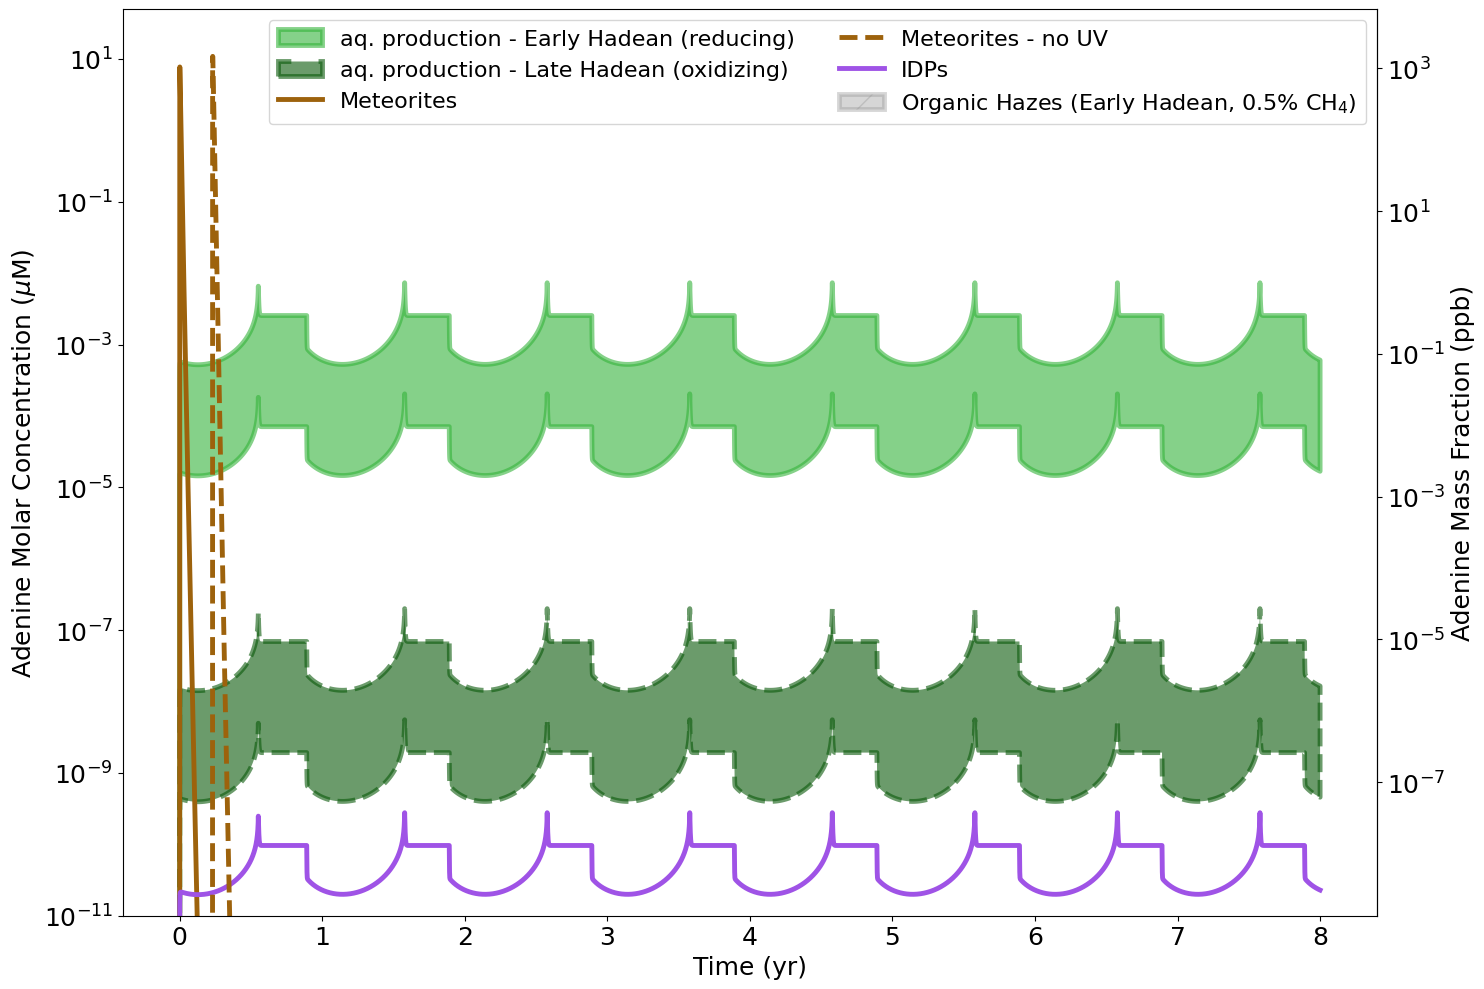

In [12]:
plt.clf()

f, ax1 = plt.subplots(1, 1, figsize=(15,10))
# f, (ax1) = plt.subplots(1, 2, figsize=(28,10))

        
p1 = ax1.fill_between(t, C_IDN_65_Adenine_red*Adenine_lower*1e6/mu_Adenine, C_IDN_65_Adenine_red*Adenine_upper*1e6/mu_Adenine, linestyle='-', color='#34b33a', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Early Hadean (reducing)', alpha=.60)
         
p2, = ax1.plot(t, C_IDN_65_Met*1e6/mu_Adenine, linestyle='-', color='#9d620c', lw=3.5, label='Meteorites - Intermediate Env.')
         
p3, = ax1.plot(t, C_IDN_65_IDP*1e6/mu_Adenine, linestyle='-', color='#9f53e6', lw=3.5, label='IDPs - Intermediate Env.')  
        
p4 = ax1.fill_between(t, C_IDN_65_Adenine_ox*Adenine_lower*1e6/mu_Adenine, C_IDN_65_Adenine_ox*Adenine_upper*1e6/mu_Adenine, linestyle='--', color='#095909', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Late Hadean (oxidizing)', alpha=.60)
                        
p5, = ax1.plot(t, C_COL_65_Met*1e6/mu_Adenine, linestyle='--', color='#9d620c', lw=3.5, label='Meteorites - Wet Env.')      
               
#p6, = ax1.plot(t, C_IDN_65_Adenine_haze5*1e6/mu_Adenine, linestyle='-', color='#a30313', lw=3.5, label='Organic Hazes (5% methane)') 
  
p7 = ax1.fill_between(t, C_IDN_65_Adenine_haze05_min*1e6/mu_Adenine, C_IDN_65_Adenine_haze05_max*1e6/mu_Adenine, linestyle='-', hatch = '/',lw=3.5, color="#999999", label='Organic Hazes (0.5% methane)',alpha=0.4)                       
     
secax = ax1.secondary_yaxis('right', functions=(molar2mass, mass2molar))

secax.set_ylabel("Adenine Mass Fraction (ppb)",fontsize=18)
#secax.set_yticklabels([1e-7,1e-5,1e-3,1e-1,1e1,1e3],fontsize=18)

ax1.set_ylim(1e-11,50.)

#ax1.text(0.222, 0.742, "1", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
#ax1.text(0.247, 0.702, "2", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
#ax1.text(0.288, 0.647, "3", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))

ax1.legend([p1,p4,p2,p5,p3,p7], [r'aq. production - Early Hadean (reducing)', r'aq. production - Late Hadean (oxidizing)','Meteorites', 'Meteorites - no UV', 'IDPs',r'Organic Hazes (Early Hadean, 0.5% CH$_4$)'], loc=1,ncol=2, fontsize=16)
ax1.set_yscale('log')

  
# ax2.plot(t, C_IDN_65_Uracil_haze05_max*1e6/mu_Uracil, linestyle='-', color='#AA3377', lw=3.5, label='Uracil')     
# ax2.plot(t, C_IDN_65_Hypoxanthine_haze05_max*1e6/mu_hypoxanthine, linestyle='--', color='#66CCEE', lw=3.5, label='Hypoxanthine')  
# ax2.plot(t, C_IDN_65_Xanthine_haze05_max*1e6/mu_xanthine, linestyle='-', color='#EE6677', lw=3.5, label='Xanthine*')   
# ax2.plot(t, C_IDN_65_Thymine_haze05_max*1e6/mu_Thymine, linestyle='--', color='#BBBBBB', lw=3.5, label='Thymine')     
# ax2.plot(t, C_IDN_65_Guanine_haze05_max*1e6/mu_Guanine, linestyle='-', color='#4477AA', lw=3.5, label='Guanine*')      
# ax2.plot(t, C_IDN_65_Cytosine_haze05_max*1e6/mu_Cytosine, linestyle='--', color='#CCBB44', lw=3.5, label='Cytosine')    


# ax2.set_yscale('log')
# ax2.set_ylim(1.e-2,20e0)

# ax2.text(-0.2,1.3e1,r"Maxima from organic hazes",fontweight='bold',fontsize=20)
# ax2.text(-0.2,1.e1,r"Early Hadean, 0.5% CH$_4$",fontweight='bold',fontsize=20)

# ax2.legend(loc=1,ncol=2,fontsize=16)

#for tick in ax1.yaxis.get_major_ticks()[::2]:
 #   tick.set_visible(False)
ax1.set_xlabel('Time (yr)', fontsize=18)
ax1.set_ylabel('Adenine Molar Concentration ($\mu$M)', fontsize=18)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
# ax2.set_xlabel('Time (yr)', fontsize=18)
# ax2.set_ylabel('Nucleobase Molar Concentration ($\mu$M)', fontsize=18)
# for tick in ax2.xaxis.get_major_ticks():
    # tick.label1.set_fontsize(18) 
# for tick in ax2.yaxis.get_major_ticks():
    # tick.label1.set_fontsize(18)

secax.tick_params(axis='both',labelsize=18)

ax1.text(-1.25, 1.7e1,'', fontsize=30, weight='bold', color='black')
# ax2.text(-1.2, 1.52e1,'B)', fontsize=30, weight='bold', color='black')


plt.tight_layout()
plt.savefig('Adenine_only_no_haze.png',dpi=300)